In [1]:
import lovely_tensors
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from scipy.stats import gamma

/home/chris/miniconda3/envs/stable-diffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lovely_tensors.monkey_patch()
torch.manual_seed(1)
torch.cuda.set_device(1)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Model 
# #####

class VAE(torch.nn.Module):
    def __init__(self, data_dim, latent_dim, n1=512, n2=256):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = torch.nn.Linear(data_dim, n1)
        self.fc2 = torch.nn.Linear(n1, n2)
        self.fc31 = torch.nn.Linear(n2, latent_dim)
        self.fc32 = torch.nn.Linear(n2, latent_dim)
        
        # decoder part
        self.fc4 = torch.nn.Linear(latent_dim, n2)
        self.fc5 = torch.nn.Linear(n2, n1)
        self.fc6 = torch.nn.Linear(n1, data_dim)
        
    def encoder(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = torch.relu(self.fc4(z))
        h = torch.relu(self.fc5(h))
        # return self.fc6(h)
        # return torch.sigmoid(self.fc6(h)) 
        return torch.relu(self.fc6(h))
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# Loss Function
# #############

def loss_function(X_tilde, X, mu, log_var, C=1):
    n = X.size(0)
    REC = (X_tilde - X).pow(2).sum()  / n
    KLD = 0.5 * torch.sum(mu.pow(2) + log_var.exp() - 1 - log_var) / n
    return C * REC + KLD, REC, KLD

# Gamma Distribution

In [4]:
BATCH_SIZE = 32
DATA_DIM = 1
LATENT_DIM = 3

# Model
vae = VAE(DATA_DIM, LATENT_DIM, n1=100, n2=100).to(DEVICE)

# Dataset
a = 1.4

x_gt = np.linspace(0, 10, 10000)
y_gt = gamma.pdf(x_gt, a)
x_gt = x_gt

x_train = gamma.rvs(a, size=10000, random_state=42)
x_val = gamma.rvs(a, size=1000, random_state=43)

class GammaDataset(torch.utils.data.Dataset):
    def __init__(self, x):
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return np.array([self.x[idx]], dtype=np.float32)

train_dataset = GammaDataset(x_train)
val_dataset = GammaDataset(x_val)

# Dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Optimizer
optimizer = torch.optim.Adam(vae.parameters())

# Training history
train_epoch_history = []
train_loss_history = []
val_epoch_history = []
val_loss_history = []

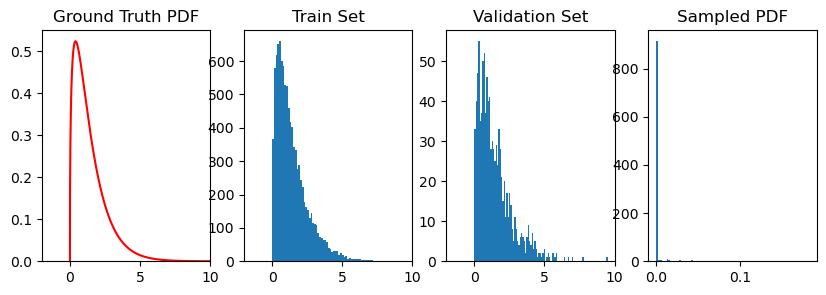

In [5]:
def sample(vae, n=1000):
    with torch.no_grad():
        z = torch.randn(n, LATENT_DIM).to(DEVICE)
        sample = vae.decoder(z).to(DEVICE)
    return sample.cpu().numpy().squeeze()    

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 3))

ax1.plot(x_gt, y_gt, color='red')
ax1.set_title("Ground Truth PDF")
ax1.set_ylim([0, None])
ax1.set_xlim(-2, 10)

x = np.concatenate([d.cpu().numpy() for d in train_loader]).squeeze()
ax2.hist(x, bins=100)
ax2.set_title("Train Set")
ax2.set_xlim(-2, 10)

x = np.concatenate([d.cpu().numpy() for d in val_loader]).squeeze()
ax3.hist(x, bins=100)
ax3.set_title("Validation Set")
ax3.set_xlim(-2, 10)

x = sample(vae)
ax4.hist(x, bins=100)
ax4.set_title("Sampled PDF")
# ax4.set_xlim(-2, 10)

plt.show()

Epoch=1.00, Loss=2.5516, Rec=0.0631, KLD=1.6054, ValidationLoss=2.6834
Epoch=2.00, Loss=2.5352, Rec=0.0585, KLD=1.6571, ValidationLoss=2.2615
Epoch=3.00, Loss=1.8870, Rec=0.0134, KLD=1.6854, ValidationLoss=2.1882
Epoch=4.00, Loss=2.2351, Rec=0.0368, KLD=1.6830, ValidationLoss=2.1973
Epoch=5.00, Loss=2.0392, Rec=0.0163, KLD=1.7946, ValidationLoss=2.2411
Epoch=6.00, Loss=2.0069, Rec=0.0187, KLD=1.7266, ValidationLoss=2.2108
Epoch=7.00, Loss=2.9439, Rec=0.0743, KLD=1.8287, ValidationLoss=2.3888
Epoch=8.00, Loss=2.3150, Rec=0.0419, KLD=1.6869, ValidationLoss=2.2353
Epoch=9.00, Loss=2.4429, Rec=0.0472, KLD=1.7342, ValidationLoss=2.2541
Epoch=10.00, Loss=1.8253, Rec=0.0061, KLD=1.7333, ValidationLoss=2.2077


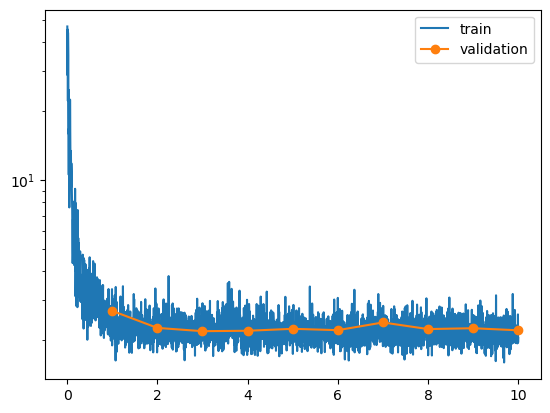

In [6]:
C = 15
n_epochs = 10
start_epoch = int(max(train_epoch_history)) if train_epoch_history else 0
for epoch in range(start_epoch, start_epoch+n_epochs):    
    
    # training 
    vae.train()
    for i, X in enumerate(train_loader):
        
        t = epoch + (i+1) / len(train_loader)
        train_epoch_history.append(t)

        # Forward Pass
        X = X.to(DEVICE)
        X_tilde, mu, log_var = vae(X)

        # Loss
        loss, rec, kld = loss_function(X_tilde, X, mu, log_var, C=C)
        train_loss_history.append(loss.item())

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss
        print(f"Epoch={t:<.2f}, Loss={loss:<.4f}, Rec={rec:<.4f}, KLD={kld:<.4f}", end='\r')

    # validation
    vae.eval()
    with torch.no_grad():
        
        # Forward Pass and Loss Evaluation
        val_loss = []
        for X in val_loader:
            X = X.to(DEVICE)
            X_tilde, mu, log_var = vae(X)
            loss, rec, kld = loss_function(X_tilde, X, mu, log_var, C=C)
            val_loss.append(loss.item())
        val_loss = np.mean(val_loss)
    
        # Logging
        val_epoch_history.append(t)
        val_loss_history.append(val_loss)
        
        # Print
        print(f"Epoch={t:<.2f}, Loss={loss:<.4f}, Rec={rec:<.4f}, KLD={kld:<.4f}, ValidationLoss={val_loss:<.4f}")

plt.plot(train_epoch_history, train_loss_history, label='train')
plt.plot(val_epoch_history, val_loss_history, label='validation', marker="o")
plt.legend()
plt.yscale('log')
plt.show()

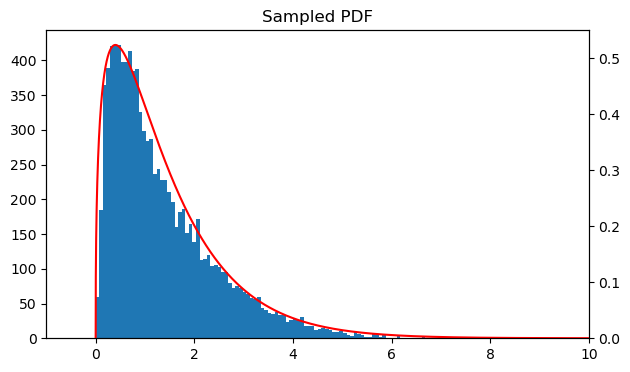

In [7]:
x = sample(vae, n=len(x_train))

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.hist(x, bins=100)
ax.set_title("Sampled PDF")
ax.set_xlim(-1, 10)

ax2 = ax.twinx()
ax2.plot(x_gt, y_gt, color='red')
ax2.set_ylim([0, None])

plt.show()

# Image Distribution

### Handwritten Digits (MNIST)

In [8]:
BATCH_SIZE = 32
DATA_DIM = 784
LATENT_DIM = 3

# Model
vae = VAE(DATA_DIM, LATENT_DIM).to(DEVICE)

# Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
val_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Optimizer
optimizer = torch.optim.Adam(vae.parameters())

# Training history
train_epoch_history = []
train_loss_history = []
val_epoch_history = []
val_loss_history = []

Epoch=1.00, Loss=39.6702, Rec=33.9542, KLD=5.7160, ValidationLoss=38.4412
Epoch=2.00, Loss=38.3397, Rec=32.3243, KLD=6.0154, ValidationLoss=37.2882
Epoch=3.00, Loss=37.8728, Rec=31.7233, KLD=6.1495, ValidationLoss=36.5748
Epoch=4.00, Loss=36.4002, Rec=29.9782, KLD=6.4220, ValidationLoss=35.7171
Epoch=5.00, Loss=35.2815, Rec=28.9935, KLD=6.2879, ValidationLoss=35.2556
Epoch=6.00, Loss=34.5760, Rec=28.3260, KLD=6.2500, ValidationLoss=35.1401
Epoch=7.00, Loss=36.3083, Rec=29.8476, KLD=6.4607, ValidationLoss=35.0069
Epoch=8.00, Loss=35.5537, Rec=29.3437, KLD=6.2100, ValidationLoss=34.6925
Epoch=9.00, Loss=36.9514, Rec=30.5720, KLD=6.3793, ValidationLoss=34.4977
Epoch=10.00, Loss=33.9369, Rec=27.5051, KLD=6.4318, ValidationLoss=34.5178


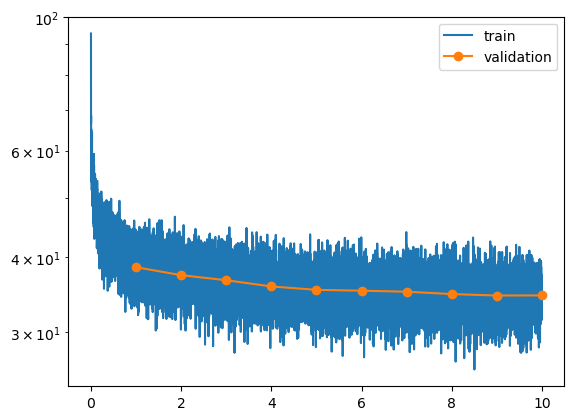

In [9]:
n_epochs = 10
start_epoch = int(max(train_epoch_history)) if train_epoch_history else 0
for epoch in range(start_epoch, start_epoch+n_epochs):    
    
    # training 
    vae.train()
    for i, (X, _) in enumerate(train_loader):
        
        t = epoch + (i+1) / len(train_loader)
        train_epoch_history.append(t)

        # Forward Pass
        X = X.to(DEVICE).view(-1, DATA_DIM)
        X_tilde, mu, log_var = vae(X)
    
        # Loss
        loss, rec, kld = loss_function(X_tilde, X, mu, log_var)
        train_loss_history.append(loss.item())

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss
        print(f"Epoch={t:<.2f}, Loss={loss:<.4f}, Rec={rec:<.4f}, KLD={kld:<.4f}", end='\r')

    # validation
    vae.eval()
    with torch.no_grad():
        
        # Forward Pass and Loss Evaluation
        val_loss = []
        for X, _ in val_loader:
            X = X.to(DEVICE).view(-1, DATA_DIM)
            X_tilde, mu, log_var = vae(X)
            loss, rec, kld = loss_function(X_tilde, X, mu, log_var)
            val_loss.append(loss.item())
        val_loss = np.mean(val_loss)
        
        # Logging
        val_epoch_history.append(t)
        val_loss_history.append(val_loss)
        
        # Print
        print(f"Epoch={t:<.2f}, Loss={loss:<.4f}, Rec={rec:<.4f}, KLD={kld:<.4f}, ValidationLoss={val_loss:<.4f}")

plt.plot(train_epoch_history, train_loss_history, label='train')
plt.plot(val_epoch_history, val_loss_history, label='validation', marker="o")
plt.legend()
plt.yscale('log')
plt.show()

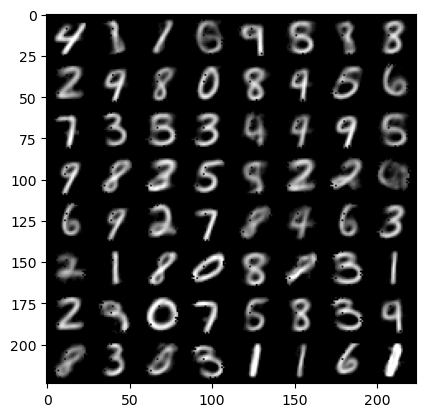

In [10]:
n = 8
with torch.no_grad():
    z = torch.randn(n*n, LATENT_DIM).to(DEVICE)
    sample = vae.decoder(z).to(DEVICE)
    img = sample.view(n,n,28,28).cpu().numpy()
    img = np.vstack(np.dstack(img))
plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.show()